# Colored Handwritten Digit Classification
A deep learning model based on CNN that recognizes handwritten digits as well as its color.

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Load the data

In [27]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.mnist.load_data()

## Colorize the data

In [57]:
# function to modify the mnist data set to be either color red or green
def colorize_data(x, y):
    c = np.random.randint(0, 2)
    image = 0.5 * np.random.rand(28, 28, 3)
    image[:, :, c] += 0.5 * x/255.0
    return image, y, c

label: 4 color: green


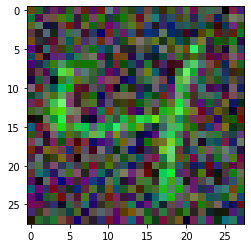

In [58]:
# show a sample of the colorized data
colors = {0: 'red', 1: 'green'}
x, y, c = colorize_data(xtrain[2], ytrain[2])
print(f'label: {y} color: {colors[c]}')
plt.imshow(x)
plt.show()

## Generate the dataset

In [59]:
def generate_data(x, y, batch_size=32):
    num_examples = len(y)

    while True:
        x_batch = np.zeros((batch_size, 28, 28, 3))
        y_batch = np.zeros((batch_size,))
        c_batch = np.zeros((batch_size,))

        for i in range(0, batch_size):
            index = np.random.randint(0, num_examples)
            image, label, color = colorize_data(x[index], y[index])
            x_batch[i] = image
            y_batch[i] = label
            c_batch[i] = color

        yield x_batch, [y_batch, c_batch]

In [60]:
x, [y, c] = next(generate_data(xtrain, ytrain, 2))

1.0, 1.0


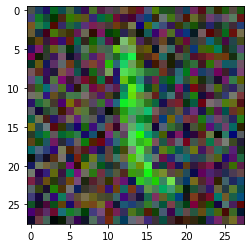

In [61]:
print(f'{y[1]}, {c[1]}')
plt.imshow(x[1])
plt.show()

In [66]:
train_gen = generate_data(xtrain, ytrain)
val_gen = generate_data(xtest, ytest)

## Create the Model

In [62]:
input_layer = tf.keras.layers.Input(shape=(28, 28, 3), name='input')
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv1')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(4, 4, name='pool1')(conv1)
flatten1 = tf.keras.layers.Flatten(name='flatten1')(pool1)
color = tf.keras.layers.Dense(1, activation='sigmoid', name='color_output')(flatten1)

conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(2, 2, name='pool2')(conv2)

flatten2 = tf.keras.layers.Flatten(name='flatten2')(pool2)
digit = tf.keras.layers.Dense(10, activation='softmax', name='digit_output')(flatten2)

model = tf.keras.models.Model(input_layer, [digit, color])

In [63]:
model.compile(loss={
    'digit_output': 'sparse_categorical_crossentropy',
    'color_output': 'binary_crossentropy'},
    optimizer='adam',
    metrics=['accuracy']
    )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 32)   896         ['input[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 6, 6, 32)     0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 4, 4, 32)     9248        ['pool1[0][0]']                  
                                                                                            

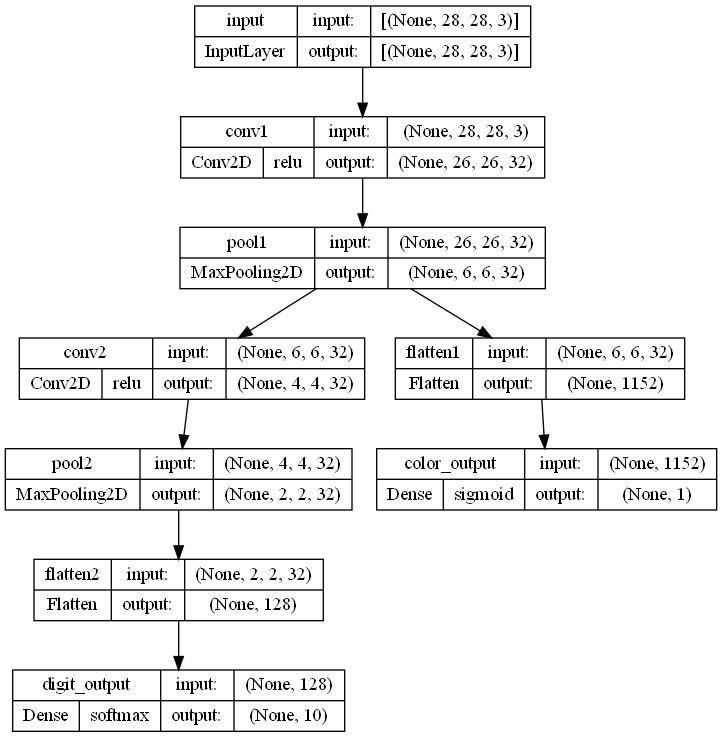

In [64]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

## Task 5: Training the Model

In [65]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_output_accuracy')
    color_accuracy = logs.get('color_output_accuracy')
    val_digit_accuracy = logs.get('val_digit_output_accuracy')
    val_color_accuracy = logs.get('val_color_output_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [67]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=200,
    validation_steps=100,
    callbacks=[Logger(), tf.keras.callbacks.TensorBoard(log_dir='./logs')]
    
)

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 2.3683 - digit_output_loss: 2.1935 - color_output_loss: 0.1748 - digit_output_accuracy: 0.2520 - color_output_accuracy: 0.9702============================== 1 ==============================
digit_accuracy: 0.25, color_accuracy: 0.97
val_digit_accuracy: 0.46, val_color_accuracy: 1.00
200/200 [==============================] - 6s 24ms/step - loss: 2.3683 - digit_output_loss: 2.1935 - color_output_loss: 0.1748 - digit_output_accuracy: 0.2520 - color_output_accuracy: 0.9702 - val_loss: 1.9127 - val_digit_output_loss: 1.9068 - val_color_output_loss: 0.0059 - val_digit_output_accuracy: 0.4619 - val_color_output_accuracy: 1.0000
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 1.4344 - digit_output_loss: 1.4327 - color_output_loss: 0.0017 - digit_output_accuracy: 0.5695 - color_output_accuracy: 1.0000============================== 2 ==============================
digit_accuracy: 0.57, color_accuracy: 1.

## Predictions using the model

In [72]:
def test_model(show=True):
  x, [y, c] = next(test)

  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])

  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(xtest, ytest, batch_size=1)

1/1 [==============================] - 0s 70ms/step
GT: 3, red
Pr: 3, red


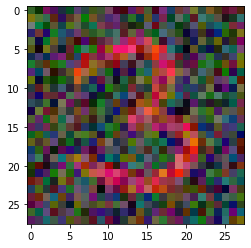

In [73]:
test_model()